In [1]:
# ================================================================
# SNAPSHELF AI - RESNET-50 TRAINING
# ================================================================
# Project:      SnapShelf - Smart Food Inventory Management
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Institution:  Anglia Ruskin University, Cambridge
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Date:         January 2026
# ================================================================
#
# PURPOSE:
# This notebook trains a ResNet-50 model using transfer learning
# for food item classification. ResNet-50 is a 50-layer deep
# residual network pre-trained on ImageNet.
#
# This is the third model in our comparison study:
#   1. Custom CNN (trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning) <- This notebook
#
# INPUT:
#   - snapshelf_dataset_14classes_70-15-15.zip (from Google Drive)
#
# OUTPUT:
#   - Trained ResNet-50 model (.keras)
#   - Training history plots
#   - Confusion matrix
#   - Performance metrics (JSON)
#
# ================================================================

In [14]:
# ================================================================
# CELL 1: ENVIRONMENT SETUP
# ================================================================
# Install required packages and verify GPU availability.
# ================================================================

import sys
import platform
from datetime import datetime

print("=" * 65)
print("SNAPSHELF AI - RESNET-50 TRAINING")
print("=" * 65)
print(f"Execution Date:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python Version:  {sys.version.split()[0]}")
print("=" * 65)

SNAPSHELF AI - RESNET-50 TRAINING
Execution Date:  2026-01-12 18:41:11
Python Version:  3.12.12


In [15]:
# ================================================================
# CELL 2: IMPORT LIBRARIES & CHECK GPU
# ================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check GPU
print("\n" + "=" * 65)
print("HARDWARE CONFIGURATION")
print("=" * 65)

if tf.config.list_physical_devices('GPU'):
    gpu = tf.config.list_physical_devices('GPU')[0]
    print(f"GPU Available: {gpu.name}")
    !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
else:
    print("WARNING: No GPU detected. Training will be slow.")

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

HARDWARE CONFIGURATION
GPU Available: /physical_device:GPU:0
Tesla T4, 15360 MiB
TensorFlow Version: 2.19.0
Keras Version: 3.10.0


In [16]:
# ================================================================
# CELL 3: MOUNT GOOGLE DRIVE & LOAD DATASET
# ================================================================
# Loads the prepared dataset from Notebook 01.
# Extracts to local storage for faster training.
# ================================================================

from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# -----------------------------
# CONFIGURATION
# -----------------------------
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"

print("=" * 65)
print("LOADING DATASET")
print("=" * 65)

# Verify zip file exists
if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset archive: {DATASET_ZIP}")
print(f"Archive size:    {zip_size_mb:.1f} MB")

# -----------------------------
# EXTRACT DATASET
# -----------------------------
print(f"\nExtracting to: {LOCAL_DATASET}")

# Clean extraction directory
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

# Extract
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)

print("Extraction complete.")

# -----------------------------
# VERIFY STRUCTURE
# -----------------------------
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

print(f"\nDataset structure:")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len(os.listdir(split_dir))
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        print(f"  {split_name}: NOT FOUND")

# Get class names
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nClasses ({NUM_CLASSES}): {', '.join(CLASS_NAMES)}")

LOADING DATASET

Dataset archive: /content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip
Archive size:    2445.3 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

Dataset structure:
  Train:   14 classes, 117,151 images
  Val:     14 classes, 25,099 images
  Test:    14 classes, 25,116 images

Classes (14): apple, banana, bell_pepper_green, bell_pepper_red, carrot, cucumber, grape, lemon, onion, orange, peach, potato, strawberry, tomato


In [17]:
# ================================================================
# CELL 4: CONFIGURE DATA GENERATORS
# ================================================================
# Set up ImageDataGenerator with augmentation for training.
# ResNet-50 uses 224x224 input size and specific preprocessing.
# ================================================================

print("=" * 65)
print("CONFIGURING DATA GENERATORS")
print("=" * 65)

# Configuration
IMG_SIZE = (224, 224)  # ResNet-50 standard input size
BATCH_SIZE = 32
SEED = 42

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Validation and test generators (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Create generators
print("\nCreating data generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nGenerator Configuration:")
print(f"  Image Size:  {IMG_SIZE}")
print(f"  Batch Size:  {BATCH_SIZE}")
print(f"  Train Batches: {len(train_generator)}")
print(f"  Val Batches:   {len(val_generator)}")
print(f"  Test Batches:  {len(test_generator)}")

CONFIGURING DATA GENERATORS

Creating data generators...
Found 117151 images belonging to 14 classes.
Found 25099 images belonging to 14 classes.
Found 25116 images belonging to 14 classes.

Generator Configuration:
  Image Size:  (224, 224)
  Batch Size:  32
  Train Batches: 3661
  Val Batches:   785
  Test Batches:  785


In [18]:
# ================================================================
# CELL 5: BUILD RESNET-50 MODEL
# ================================================================
# Load pre-trained ResNet-50 and add custom classification head.
# ================================================================

print("=" * 65)
print("BUILDING RESNET-50 MODEL")
print("=" * 65)

# Load pre-trained ResNet-50 (without top classification layer)
print("\nLoading pre-trained ResNet-50...")
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers initially
base_model.trainable = False

print(f"Base model loaded: {base_model.name}")
print(f"Base model layers: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")

# Build complete model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n" + "=" * 65)
print("MODEL ARCHITECTURE")
print("=" * 65)
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nParameter Count:")
print(f"  Total:         {total_params:,}")
print(f"  Trainable:     {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")

BUILDING RESNET-50 MODEL

Loading pre-trained ResNet-50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Base model loaded: resnet50
Base model layers: 175
Base model trainable: False

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,125,070 (92.03 MB)

 Trainable params: 532,750 (2.03 MB)

 Non-trainable params: 23,592,320 (90.00 MB)


Parameter Count:
  Total:         24,125,070
  Trainable:     532,750
  Non-trainable: 23,592,320


In [19]:
# ================================================================
# CELL 6: PHASE 1 TRAINING (FROZEN BASE)
# ================================================================
# Train only the classification head with frozen ResNet base.
# ================================================================

print("=" * 65)
print("PHASE 1: TRAINING CLASSIFICATION HEAD")
print("=" * 65)
print("(Base model frozen - training new layers only)")

# Callbacks
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Record start time
phase1_start = datetime.now()
print(f"\nPhase 1 started at: {phase1_start.strftime('%H:%M:%S')}")

# Train Phase 1
PHASE1_EPOCHS = 10

history_phase1 = model.fit(
    train_generator,
    epochs=PHASE1_EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

phase1_end = datetime.now()
phase1_duration = phase1_end - phase1_start

print(f"\nPhase 1 completed at: {phase1_end.strftime('%H:%M:%S')}")
print(f"Phase 1 duration: {phase1_duration}")
print(f"Phase 1 best val_accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

PHASE 1: TRAINING CLASSIFICATION HEAD
(Base model frozen - training new layers only)

Phase 1 started at: 18:42:28


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1226s 331ms/step - accuracy: 0.9367 - loss: 0.2219 - val_accuracy: 0.9929 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 2/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1202s 328ms/step - accuracy: 0.9841 - loss: 0.0470 - val_accuracy: 0.9946 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 3/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1204s 329ms/step - accuracy: 0.9878 - loss: 0.0362 - val_accuracy: 0.9951 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 4/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1202s 328ms/step - accuracy: 0.9897 - loss: 0.0309 - val_accuracy: 0.9954 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 5/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1206s 329ms/step - accuracy: 0.9910 - loss: 0.0261 - val_accuracy: 0.9959 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 6/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1196s 327ms/step - accuracy: 0.9913 - loss: 0.0250 - val_accuracy: 0.9958 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 7/10
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1191

In [20]:
# ================================================================
# CELL 7: PHASE 2 TRAINING (FINE-TUNING)
# ================================================================
# Unfreeze top layers of ResNet and fine-tune with lower learning rate.
# ================================================================

print("=" * 65)
print("PHASE 2: FINE-TUNING")
print("=" * 65)
print("(Unfreezing top layers of ResNet-50)")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze early layers, unfreeze later layers
# ResNet-50 has 175 layers - we'll unfreeze the last ~50 layers
FINE_TUNE_FROM = 140

for layer in base_model.layers[:FINE_TUNE_FROM]:
    layer.trainable = False

# Count trainable params after unfreezing
trainable_params_phase2 = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\nFine-tuning from layer: {FINE_TUNE_FROM}")
print(f"Trainable parameters: {trainable_params_phase2:,}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/resnet50_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Record start time
phase2_start = datetime.now()
print(f"\nPhase 2 started at: {phase2_start.strftime('%H:%M:%S')}")

# Train Phase 2
PHASE2_EPOCHS = 20

history_phase2 = model.fit(
    train_generator,
    epochs=PHASE2_EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

phase2_end = datetime.now()
phase2_duration = phase2_end - phase2_start

print(f"\nPhase 2 completed at: {phase2_end.strftime('%H:%M:%S')}")
print(f"Phase 2 duration: {phase2_duration}")
print(f"Phase 2 best val_accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

# Total training time
total_training_time = phase1_duration + phase2_duration
TRAINING_TIME_SECONDS = total_training_time.total_seconds()

print(f"\n{'=' * 40}")
print(f"TOTAL TRAINING TIME: {total_training_time}")
print(f"{'=' * 40}")

PHASE 2: FINE-TUNING
(Unfreezing top layers of ResNet-50)

Fine-tuning from layer: 140
Trainable parameters: 15,510,798

Phase 2 started at: 22:02:49
Epoch 1/20
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9858 - loss: 0.0453
Epoch 1: val_accuracy improved from -inf to 0.99618, saving model to /content/resnet50_best.keras
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1250s 336ms/step - accuracy: 0.9858 - loss: 0.0453 - val_accuracy: 0.9962 - val_loss: 0.0115 - learning_rate: 1.0000e-04
Epoch 2/20
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9944 - loss: 0.0171
Epoch 2: val_accuracy improved from 0.99618 to 0.99629, saving model to /content/resnet50_best.keras
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 1208s 330ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.9963 - val_loss: 0.0123 - learning_rate: 1.0000e-04
Epoch 3/20
3661/3661 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9955 - loss: 0.0130
Epoch 3: val_accuracy improved from 0.99629 to 0.99661, saving model to /cont

TRAINING HISTORY


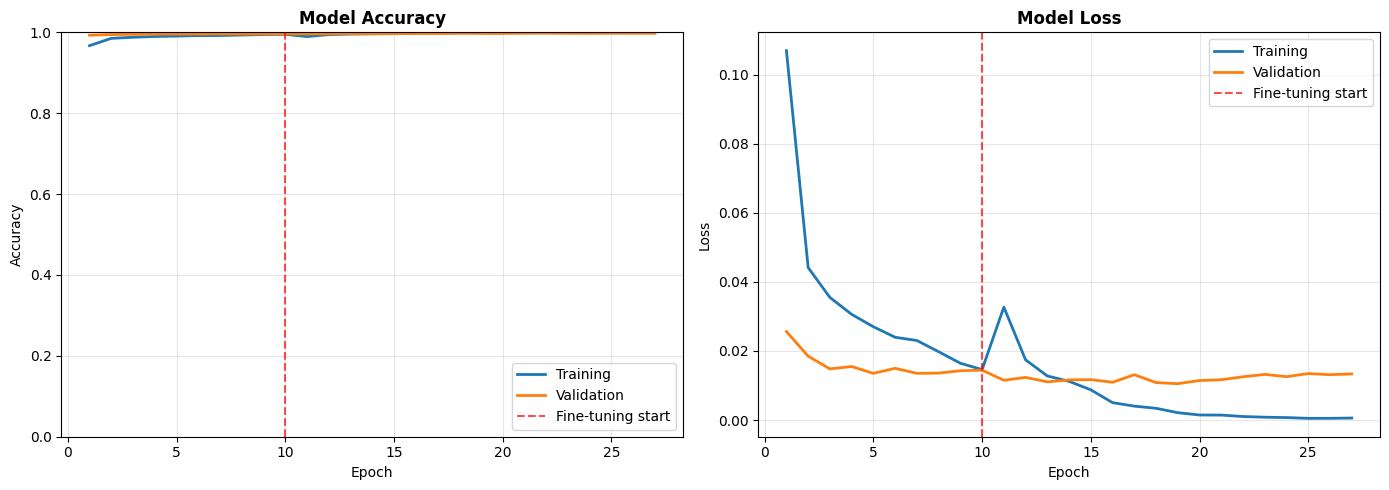


Training Summary:
  Total epochs:      27
  Phase 1 epochs:    10
  Phase 2 epochs:    17
  Best val_accuracy: 0.9978

Plot saved to: /content/resnet50_training_history.png


In [21]:
# ================================================================
# CELL 8: PLOT TRAINING HISTORY
# ================================================================
# Visualize training metrics across both phases.
# ================================================================

print("=" * 65)
print("TRAINING HISTORY")
print("=" * 65)

# Combine histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_histories(history_phase1, history_phase2)
total_epochs = len(combined_history['accuracy'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(range(1, total_epochs + 1), combined_history['accuracy'], label='Training', linewidth=2)
axes[0].plot(range(1, total_epochs + 1), combined_history['val_accuracy'], label='Validation', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--',
                label='Fine-tuning start', alpha=0.7)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss plot
axes[1].plot(range(1, total_epochs + 1), combined_history['loss'], label='Training', linewidth=2)
axes[1].plot(range(1, total_epochs + 1), combined_history['val_loss'], label='Validation', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--',
                label='Fine-tuning start', alpha=0.7)
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/resnet50_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining Summary:")
print(f"  Total epochs:      {total_epochs}")
print(f"  Phase 1 epochs:    {len(history_phase1.history['accuracy'])}")
print(f"  Phase 2 epochs:    {len(history_phase2.history['accuracy'])}")
print(f"  Best val_accuracy: {max(combined_history['val_accuracy']):.4f}")
print(f"\nPlot saved to: /content/resnet50_training_history.png")

In [22]:
# ================================================================
# CELL 9: EVALUATE ON TEST SET
# ================================================================
# Final evaluation on the held-out test set.
# ================================================================

print("=" * 65)
print("TEST SET EVALUATION")
print("=" * 65)

# Load best model
model = keras.models.load_model('/content/resnet50_best.keras')
print("Loaded best model from checkpoint.")

# Evaluate
print(f"\nEvaluating on {test_generator.samples} test images...")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'=' * 40}")
print("TEST RESULTS")
print(f"{'=' * 40}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

TEST SET EVALUATION
Loaded best model from checkpoint.

Evaluating on 25116 test images...
785/785 ━━━━━━━━━━━━━━━━━━━━ 73s 86ms/step - accuracy: 0.9979 - loss: 0.0126

TEST RESULTS
Test Loss:     0.0142
Test Accuracy: 0.9978 (99.78%)


In [ ]:
# ================================================================
# CELL 10: DETAILED CLASSIFICATION METRICS
# ================================================================
# Generate predictions and compute per-class metrics.
# ================================================================

print("=" * 65)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 65)

# Generate predictions
print("\nGenerating predictions on test set...")

test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\n" + "=" * 65)
print("CLASSIFICATION REPORT")
print("=" * 65)

report = classification_report(
    true_classes,
    predicted_classes,
    target_names=CLASS_NAMES,
    digits=4
)
print(report)

# Store as dictionary
report_dict = classification_report(
    true_classes,
    predicted_classes,
    target_names=CLASS_NAMES,
    output_dict=True
)

In [ ]:
# ================================================================
# CELL 11: CONFUSION MATRIX
# ================================================================
# Visualize classification performance across all classes.
# ================================================================

print("=" * 65)
print("CONFUSION MATRIX")
print("=" * 65)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - ResNet-50', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/resnet50_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to: /content/resnet50_confusion_matrix.png")

In [25]:
# ================================================================
# CELL 12: MEASURE INFERENCE TIME
# ================================================================
# Benchmark inference speed for single and batch predictions.
# ================================================================

print("=" * 65)
print("INFERENCE TIME MEASUREMENT")
print("=" * 65)

# Get a batch of test images
test_generator.reset()
test_batch, _ = next(test_generator)
single_image = test_batch[0:1]

# Warm-up
_ = model.predict(single_image, verbose=0)

# -----------------------------
# SINGLE IMAGE INFERENCE
# -----------------------------
print("\nMeasuring single image inference time...")

n_runs = 100
times = []

for _ in range(n_runs):
    start = time.perf_counter()
    _ = model.predict(single_image, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)

single_avg = np.mean(times)
single_std = np.std(times)

print(f"  Runs:          {n_runs}")
print(f"  Average:       {single_avg:.2f} ms")
print(f"  Std Dev:       {single_std:.2f} ms")

# -----------------------------
# BATCH INFERENCE
# -----------------------------
print("\nMeasuring batch inference time...")

n_runs = 50
times = []

for _ in range(n_runs):
    start = time.perf_counter()
    _ = model.predict(test_batch, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)

batch_avg = np.mean(times)
batch_std = np.std(times)
per_image_batch = batch_avg / len(test_batch)

print(f"  Batch size:    {len(test_batch)}")
print(f"  Runs:          {n_runs}")
print(f"  Batch avg:     {batch_avg:.2f} ms")
print(f"  Per image:     {per_image_batch:.2f} ms")

# Store results
INFERENCE_TIME_SINGLE = single_avg
INFERENCE_TIME_BATCH = per_image_batch

print(f"\n{'=' * 40}")
print("INFERENCE TIME SUMMARY")
print(f"{'=' * 40}")
print(f"Single image:   {INFERENCE_TIME_SINGLE:.2f} ms")
print(f"Batched (x{len(test_batch)}):  {INFERENCE_TIME_BATCH:.2f} ms per image")

INFERENCE TIME MEASUREMENT

Measuring single image inference time...
  Runs:          100
  Average:       67.57 ms
  Std Dev:       3.61 ms

Measuring batch inference time...
  Batch size:    32
  Runs:          50
  Batch avg:     216.22 ms
  Per image:     6.76 ms

INFERENCE TIME SUMMARY
Single image:   67.57 ms
Batched (x32):  6.76 ms per image


In [26]:
# ================================================================
# CELL 13: SAVE MODEL & RESULTS
# ================================================================
# Save the trained model and all metrics to Google Drive.
# ================================================================

print("=" * 65)
print("SAVING MODEL & RESULTS")
print("=" * 65)

# Create output directory
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# -----------------------------
# SAVE MODEL
# -----------------------------
MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/resnet50_model.keras"

print(f"\nSaving model to: {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

# Get model file size
model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# -----------------------------
# COMPILE RESULTS
# -----------------------------
results_data = {
    "model_name": "ResNet-50",
    "architecture": {
        "type": "ResNet-50 Transfer Learning",
        "base_model": "ResNet50",
        "pretrained_on": "ImageNet",
        "fine_tuned_from_layer": FINE_TUNE_FROM,
        "input_size": [224, 224, 3],
        "num_classes": NUM_CLASSES
    },
    "training": {
        "phase1_epochs": len(history_phase1.history['accuracy']),
        "phase2_epochs": len(history_phase2.history['accuracy']),
        "total_epochs": total_epochs,
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE
    },
    "performance": {
        "test_loss": float(test_loss),
        "test_accuracy": float(test_accuracy),
        "best_val_accuracy": float(max(combined_history['val_accuracy']))
    },
    "per_class_metrics": {
        class_name: {
            "precision": report_dict[class_name]["precision"],
            "recall": report_dict[class_name]["recall"],
            "f1_score": report_dict[class_name]["f1-score"],
            "support": report_dict[class_name]["support"]
        }
        for class_name in CLASS_NAMES
    },
    "efficiency": {
        "model_size_mb": round(model_size_mb, 2),
        "total_parameters": int(total_params),
        "trainable_parameters_phase2": int(trainable_params_phase2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# -----------------------------
# SAVE RESULTS JSON
# -----------------------------
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/resnet50_results.json"

print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results_data, f, indent=2)
print("Results saved successfully.")

# -----------------------------
# SAVE PLOTS TO DRIVE
# -----------------------------
import shutil

print(f"\nSaving plots to Drive...")
shutil.copy('/content/resnet50_training_history.png',
            f"{DRIVE_MODEL_DIR}/resnet50_training_history.png")
shutil.copy('/content/resnet50_confusion_matrix.png',
            f"{DRIVE_MODEL_DIR}/resnet50_confusion_matrix.png")
print("Plots saved successfully.")

# -----------------------------
# PRINT FINAL SUMMARY
# -----------------------------
print("\n" + "=" * 65)
print("RESNET-50 - FINAL RESULTS SUMMARY")
print("=" * 65)

print(f"""
MODEL ARCHITECTURE
------------------
Type:               ResNet-50 Transfer Learning
Base Model:         ResNet50 (ImageNet)
Fine-tuned from:    Layer {FINE_TUNE_FROM}
Input Size:         224x224x3
Total Parameters:   {total_params:,}
Model Size:         {model_size_mb:.2f} MB

TRAINING
--------
Phase 1 (frozen):   {len(history_phase1.history['accuracy'])} epochs
Phase 2 (fine-tune):{len(history_phase2.history['accuracy'])} epochs
Total Time:         {total_training_time}

PERFORMANCE
-----------
Test Accuracy:      {test_accuracy * 100:.2f}%
Test Loss:          {test_loss:.4f}
Best Val Accuracy:  {max(combined_history['val_accuracy']) * 100:.2f}%

EFFICIENCY
----------
Inference (single): {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):  {INFERENCE_TIME_BATCH:.2f} ms/image

FILES SAVED
-----------
Model:    {MODEL_SAVE_PATH}
Results:  {RESULTS_PATH}
Plots:    {DRIVE_MODEL_DIR}/resnet50_*.png
""")

print("=" * 65)
print("NOTEBOOK 04 COMPLETE - RESNET-50 TRAINING FINISHED")
print("=" * 65)

SAVING MODEL & RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models/resnet50_model.keras
Model saved successfully.

Saving results to: /content/drive/MyDrive/snapshelf_models/resnet50_results.json
Results saved successfully.

Saving plots to Drive...
Plots saved successfully.

RESNET-50 - FINAL RESULTS SUMMARY

MODEL ARCHITECTURE
------------------
Type:               ResNet-50 Transfer Learning
Base Model:         ResNet50 (ImageNet)
Fine-tuned from:    Layer 140
Input Size:         224x224x3
Total Parameters:   24,125,070
Model Size:         211.03 MB

TRAINING
--------
Phase 1 (frozen):   10 epochs
Phase 2 (fine-tune):17 epochs
Total Time:         9:06:19.437513

PERFORMANCE
-----------
Test Accuracy:      99.78%
Test Loss:          0.0142
Best Val Accuracy:  99.78%

EFFICIENCY
----------
Inference (single): 67.57 ms
Inference (batch):  6.76 ms/image

FILES SAVED
-----------
Model:    /content/drive/MyDrive/snapshelf_models/resnet50_model.keras
Results:  /content/drive/